# Defining valuable voxels for the building to select greenery

In this notebook, all voxel values are being calculated, and the space for ground floor greenery is being determined based on where the voxels are of low value for the growht of the building. 

## 0. Initialization

### 0.1. Load required libraries

In [6]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from scipy.interpolate import RegularGridInterpolator

In [7]:
# extra import function
def lattice_from_csv(file_path):
    # read metadata
    meta_df = pd.read_csv(file_path, nrows=3)

    shape = np.array(meta_df['shape'])
    unit = np.array(meta_df['unit'])
    minbound = np.array(meta_df['minbound'])

    # read lattice
    lattice_df = pd.read_csv(file_path, skiprows=5)

    # create the buffer
    buffer = np.array(lattice_df['value']).reshape(shape)

    # create the lattice
    l = tg.to_lattice(buffer, minbound=minbound, unit=unit)

    return l

### 0.2. Define the Neighborhood (Stencil)

In [8]:
# loading the lattice from csv
sun_acc_path = os.path.relpath('../data/sun_access_highres.csv')
sun_acc_lattice = lattice_from_csv(sun_acc_path)

ent_acc_highres_public_path = os.path.relpath('../data/ent_access_highres_public.csv')
ent_acc_public_lattice = lattice_from_csv(ent_acc_highres_public_path)

ent_acc_highres_housing_path = os.path.relpath('../data/ent_access_highres_housing.csv')
ent_acc_housing_lattice = lattice_from_csv(ent_acc_highres_housing_path)

ent_acc_highres_gym_path = os.path.relpath('../data/ent_access_highres_gym.csv')
ent_acc_gym_lattice = lattice_from_csv(ent_acc_highres_gym_path)

ent_acc_highres_parking_path = os.path.relpath('../data/ent_access_highres_parking.csv')
ent_acc_parking_lattice = lattice_from_csv(ent_acc_highres_parking_path)

ent_acc_highres_comcen_path = os.path.relpath('../data/ent_access_highres_comcen.csv')
ent_acc_comcen_lattice = lattice_from_csv(ent_acc_highres_comcen_path)

highres_sky_acc_path = os.path.relpath('../data/sky_access_highres.csv')
sky_acc_lattice = lattice_from_csv(highres_sky_acc_path)

highres_groundfloor = os.path.relpath('../data/ent_access_highres_groundfloor.csv')
groundfloor_lattice = lattice_from_csv(highres_groundfloor)


# list the environment information layers (lattices)
env_info = {"sun_acc": sun_acc_lattice,
            "ent_acc_public": ent_acc_public_lattice, 
            "ent_acc_housing": ent_acc_housing_lattice, 
            "ent_acc_gym": ent_acc_gym_lattice,
            "ent_acc_parking": ent_acc_parking_lattice, 
            "ent_acc_comcen": ent_acc_comcen_lattice,
            "sky_acc": sky_acc_lattice,
            "ground_floor": groundfloor_lattice}

### 0.3. Load the envelope lattice as the avialbility lattice

In [9]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/new_shadremove_envelope_lattice.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)

### 1.1 calculating an average value lattice 

In [10]:
avail_index = np.array(np.where(avail_lattice == 1)).T
# initializing a sum lattice
val_lattice = avail_lattice * 0.0 + 1.0

# adding all the value of all information lattices
for key, info_lattice in env_info.items():
    val_lattice *= info_lattice

val_lattice *= avail_lattice

### 1.2. calculating a 2d space value, extract it to the full lattice and normalize

In [11]:
# sum all values in z-axis to generate a value of 
distance_lattice = avail_lattice * 0.0
column_sum = np.sum(val_lattice, axis = 2)

# copy this 2d value to all voxels in z-value
distance_lattice += column_sum[:, :, np.newaxis]

#find the maximum valid value
max_valid = np.ma.masked_invalid(distance_lattice).max()

# mapping the values from (0, max) to (1, 0)
values_normalized = distance_lattice / np.max(distance_lattice)

### 1.3. Visualize the distance lattice

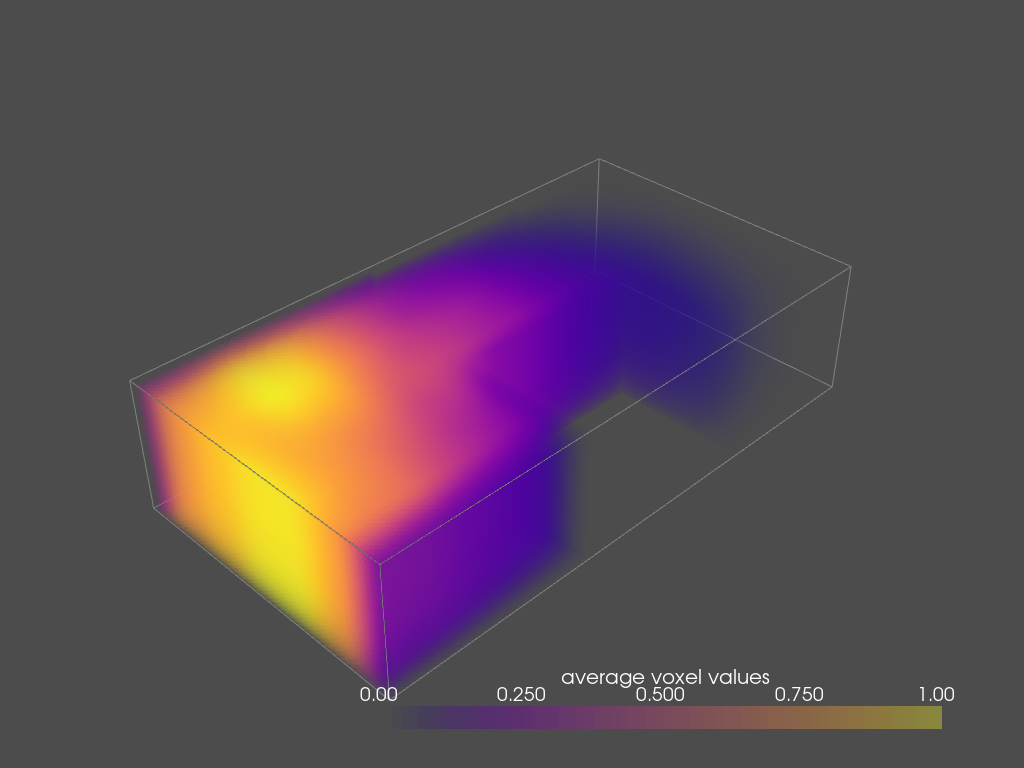

[(232.42058333192392, 138.8205833319239, 214.4205833319239),
 (36.000000000000014, -57.6, 18.0),
 (0.0, 0.0, 1.0)]

In [18]:
# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh


base_lattice = values_normalized


# load the mesh from file
# context_path = os.path.relpath('../data/immediate_context.obj')
# context_mesh = tm.load(context_path)

# initiating the plotter
p = pv.Plotter(notebook=True)

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = base_lattice.shape
# The bottom left corner of the data set
grid.origin = base_lattice.minbound
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit

# Add the data values to the cell data
grid.point_arrays["average voxel values"] = base_lattice.flatten(order="F")  # Flatten the Lattice

# adding the meshes
# p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')

p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the volume
opacity = np.array([0.0,0.6,0.6,0.6,0.6,0.6,0.6]) * 0.6
p.add_volume(grid, cmap="plasma", clim=[0.0, 1] ,opacity=opacity)

#saving and plotting
png_path = os.path.relpath('../screenshots/4.2_new_avail_lattice.png')
p.show(screenshot= png_path)

### 1.4. Determine a threshold for the growth model, where at least 30% of the groundfloor is excluded

In [39]:

high_threshold = 1.0
# find the maximum of voxels that can be grown, keeping enough space for greenery

needed_greenery_vox = 84*47*21*0.3
sum_vox = new_avail_lattice.size
max_vox = sum_vox - needed_greenery_vox
print(max_vox)

low_threshold = 0.19

new_avail_lattice = ((values_normalized < high_threshold) * (values_normalized > low_threshold)) * avail_lattice
avail_index = np.array(np.where(new_avail_lattice != 0.0)).T
avail_index.size

59022.600000000006


58365

### 1.5. visualize new availability lattice

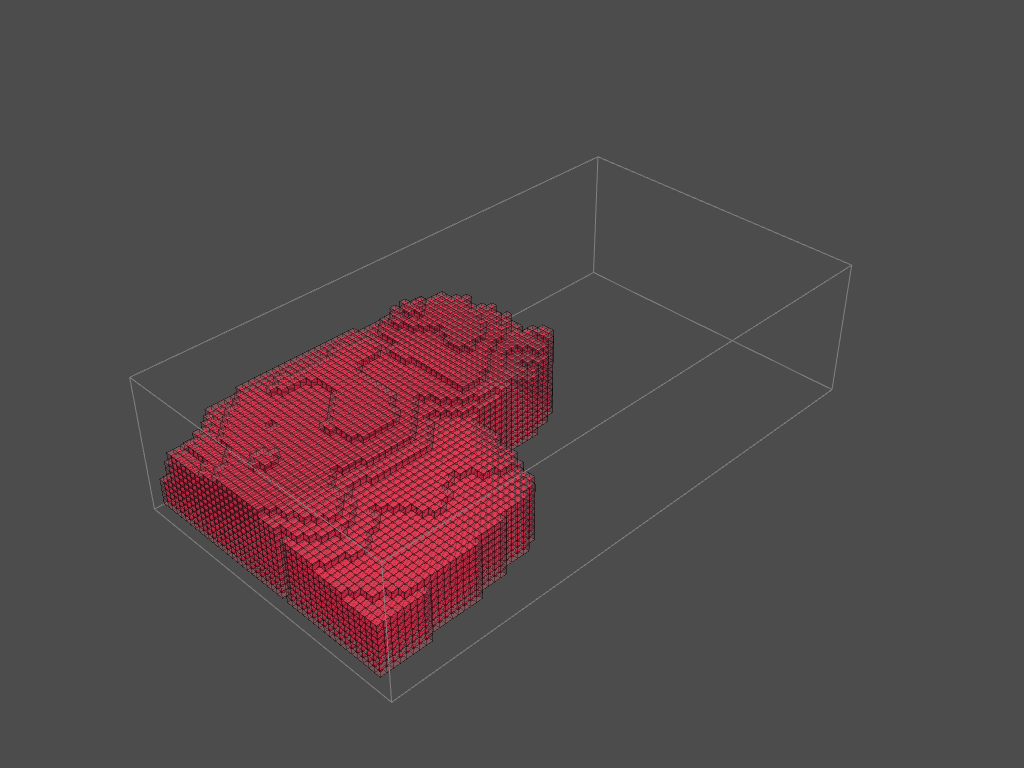

[(235.5051936291799, 141.90519277087301, 217.50519440404028),
 (36.0, -57.600000858306885, 18.000000774860382),
 (0.0, 0.0, 1.0)]

In [17]:
# convert trimesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

# Visualize the voxelization using pyvista plotter
#####

# initiating the plotter
p = pv.Plotter(notebook=True)

# fast visualization of the lattice
new_avail_lattice.fast_vis(p)

# # adding the base mesh: light blue
# p.add_mesh(tri_to_pv(mesh), color='#abd8ff', opacity=0.1)

#saving and plotting
png_path = os.path.relpath('../screenshots/4.2_new_avail_lattice.png')
p.show(screenshot= png_path)

### 1.6. Save Entrance Access Lattice to CSV

In [ ]:
# save the sun access latice to csv
csv_path = os.path.relpath('../data/avail_lattice_good_voxels.csv')
new_avail_lattice.to_csv(csv_path)

### Credits

In [17]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__editor__ = "Maartje Damen"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on MCDA and Path Finding for Generative Spatial Relations"